In [61]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)  

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

In [62]:
#Metemos un numero de prueba, el 7 ene ste caso, para probar que funciona
nqubits = 4
number = 7
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/8,0)
qc.p(number*pi/4,1)
qc.p(number*pi/2,2)
qc.p(number*pi,3)

qc.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤ P(7π/8) ├
     ├───┤├─────────┤
q_1: ┤ H ├┤ P(7π/4) ├
     ├───┤├─────────┤
q_2: ┤ H ├┤ P(7π/2) ├
     ├───┤└┬───────┬┘
q_3: ┤ H ├─┤ P(7π) ├─
     └───┘ └───────┘

In [63]:
#Aunque lo que se pide es solo la QFT, si queremos probar que funciona, aplicamos la inversa
qc = inverse_qft(qc,nqubits)
qc.measure_all()
qc.draw()

┌─────────┐┌─────────────┐      ┌───┐                           »
   q_0: ┤ U2(0,π) ├┤ U(0,0,7π/8) ├────X─┤ H ├─────■─────────────────────»
        ├─────────┤├─────────────┤    │ └───┘┌────┴────┐┌───┐           »
   q_1: ┤ U2(0,π) ├┤ U(0,0,7π/4) ├─X──┼──────┤ P(-π/2) ├┤ H ├─────■─────»
        ├─────────┤├─────────────┤ │  │      └─────────┘└───┘┌────┴────┐»
   q_2: ┤ U2(0,π) ├┤ U(0,0,7π/2) ├─X──┼──────────────────────┤ P(-π/2) ├»
        ├─────────┤└┬───────────┬┘    │                      └─────────┘»
   q_3: ┤ U2(0,π) ├─┤ U(0,0,7π) ├─────X─────────────────────────────────»
        └─────────┘ └───────────┘                                       »
meas: 4/════════════════════════════════════════════════════════════════»
                                                                        »
«                                                               ░ ┌─┐         
«   q_0: ─────■─────────────────────────────────────■───────────░─┤M├─────────
«             │                                     │           ░ └╥┘┌─┐      
«   q_1: ─────┼──────────────────────────■──────────┼───────────░──╫─┤M├──────
«        ┌────┴────┐┌───┐                │          │           ░  ║ └╥┘┌─┐   
«   q_2: ┤ P(-π/4) ├┤ H ├─────■──────────┼──────────┼───────────░──╫──╫─┤M├───
«        └─────────┘└───┘┌────┴────┐┌────┴────┐┌────┴────┐┌───┐ ░  ║  ║ └╥┘┌─┐
«   q_3: ────────────────┤ P(-π/2) ├┤ P(-π/4) ├┤ P(-π/8) ├┤ H ├─░──╫──╫──╫─┤M├
«                        └─────────┘└─────────┘└─────────┘└───┘ ░  ║  ║  ║ └╥┘
«meas: 4/══════════════════════════════════════════════════════════╩══╩══╩══╩═
«                                                                  0  1  2  3

In [64]:
from qiskit import *

IBMQ.save_account('95d7606045a3360b89085d323d855372ccd4148396391fab24c3950349608575b7dff70964afc6803168bcedb1826fb3437c3e86658d447eccb9233795c8c3dc', overwrite=True)
import numpy as np
from qiskit.visualization import plot_histogram
%matplotlib inline

provider = IBMQ.load_account()
backend = provider.backends.ibmq_santiago
qobj = assemble(transpile(qc, backend=backend), backend=backend)
job = backend.run(qobj)
retrieved_job = backend.retrieve_job(job.job_id())

/home/feynman/anaconda3/envs/qiskitEnv/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


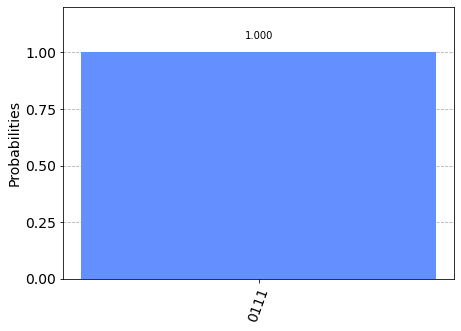

In [35]:
import numpy as np
from qiskit import(
  QuantumCircuit,
  execute,
  Aer)
from qiskit.visualization import plot_histogram

# Usamos el qasm_simulator de Aer
simulator = Aer.get_backend('qasm_simulator')
# Creamos un objeto Quantum Circuit que actúa sobre el registro cuántico por defecto (q) 
# de un bit (primer parámetro) y que tiene un registro clásico de un bit (segundo parámetro)
circuit = qc
# Ejecutamos el circuito sobre el simulador qasm
job = execute(circuit, simulator, shots=1000)
# Almacenamos los resultados
result = job.result()
# Capturamos las ocurrencias de salida
counts = result.get_counts(circuit)
plot_histogram(counts)

In [ ]:
#Ahora vamos a probar la AQFT

In [65]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)  

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """AQFT on the first n qubits in circuit"""
    qft_rotations(circuit, n-1)
    swap_registers(circuit, n)
    return circuit

def inverse_qft(circuit, n):
    """Does the inverse AQFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

In [66]:
#Metemos un numero de prueba, el 7 ene ste caso, para probar que funciona
nqubits = 4
number = 7
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/8,0)
qc.p(number*pi/4,1)
qc.p(number*pi/2,2)
qc.p(number*pi,3)

qc.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤ P(7π/8) ├
     ├───┤├─────────┤
q_1: ┤ H ├┤ P(7π/4) ├
     ├───┤├─────────┤
q_2: ┤ H ├┤ P(7π/2) ├
     ├───┤└┬───────┬┘
q_3: ┤ H ├─┤ P(7π) ├─
     └───┘ └───────┘

In [67]:
#Aunque lo que se pide es solo la QFT, si queremos probar que funciona, aplicamos la inversa
qc = inverse_qft(qc,nqubits)
qc.measure_all()
qc.draw()

┌─────────┐┌─────────────┐      ┌───┐                           »
   q_0: ┤ U2(0,π) ├┤ U(0,0,7π/8) ├────X─┤ H ├─────■─────────────────────»
        ├─────────┤├─────────────┤    │ └───┘┌────┴────┐┌───┐           »
   q_1: ┤ U2(0,π) ├┤ U(0,0,7π/4) ├─X──┼──────┤ P(-π/2) ├┤ H ├─────■─────»
        ├─────────┤├─────────────┤ │  │      └─────────┘└───┘┌────┴────┐»
   q_2: ┤ U2(0,π) ├┤ U(0,0,7π/2) ├─X──┼──────────────────────┤ P(-π/2) ├»
        ├─────────┤└┬───────────┬┘    │                      └─────────┘»
   q_3: ┤ U2(0,π) ├─┤ U(0,0,7π) ├─────X─────────────────────────────────»
        └─────────┘ └───────────┘                                       »
meas: 4/════════════════════════════════════════════════════════════════»
                                                                        »
«                         ░ ┌─┐         
«   q_0: ─────■───────────░─┤M├─────────
«             │           ░ └╥┘┌─┐      
«   q_1: ─────┼───────────░──╫─┤M├──────
«        ┌────┴────┐┌───┐ ░  ║ └╥┘┌─┐   
«   q_2: ┤ P(-π/4) ├┤ H ├─░──╫──╫─┤M├───
«        └─────────┘└───┘ ░  ║  ║ └╥┘┌─┐
«   q_3: ─────────────────░──╫──╫──╫─┤M├
«                         ░  ║  ║  ║ └╥┘
«meas: 4/════════════════════╩══╩══╩══╩═
«                            0  1  2  3

In [68]:
from qiskit import *

IBMQ.save_account('95d7606045a3360b89085d323d855372ccd4148396391fab24c3950349608575b7dff70964afc6803168bcedb1826fb3437c3e86658d447eccb9233795c8c3dc', overwrite=True)
import numpy as np
from qiskit.visualization import plot_histogram
%matplotlib inline

provider = IBMQ.load_account()
backend = provider.backends.ibmq_santiago
qobj = assemble(transpile(qc, backend=backend), backend=backend)
job = backend.run(qobj)
retrieved_job = backend.retrieve_job(job.job_id())

ibmqfactory.load_account:WARNING:2021-04-18 21:23:33,233: Credentials are already in use. The existing account in the session will be replaced.


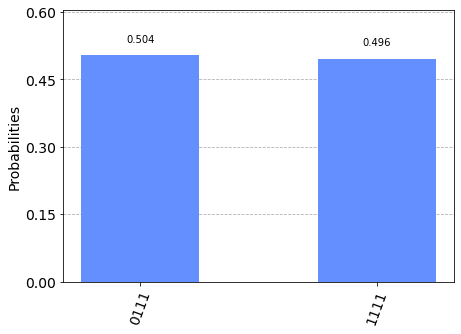

In [60]:
import numpy as np
from qiskit import(
  QuantumCircuit,
  execute,
  Aer)
from qiskit.visualization import plot_histogram

# Usamos el qasm_simulator de Aer
simulator = Aer.get_backend('qasm_simulator')
# Creamos un objeto Quantum Circuit que actúa sobre el registro cuántico por defecto (q) 
# de un bit (primer parámetro) y que tiene un registro clásico de un bit (segundo parámetro)
circuit = qc
# Ejecutamos el circuito sobre el simulador qasm
job = execute(circuit, simulator, shots=1000)
# Almacenamos los resultados
result = job.result()
# Capturamos las ocurrencias de salida
counts = result.get_counts(circuit)
plot_histogram(counts)

In [ ]:
#En simulado el 50% de las veces arroja el resultado que queremos, '7', seguramente es porque hay alguna puerta H
#mal colocada, la AQFT se implementa poniendo n=numero
#de rotaciones que queremos cuando llamamos a la funcion qft_rotations()
#Los reultados en real tanto de la QFT como de la AQFT arrojan una 40% de frecuencia del numero 7, aunque es
#la frecuencia mas alta de todas y es la correcta(el numero 7 en este caso), tiene un 60% de error, por lo que
#es bastant mejorable